In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTENC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv')

train_df = train_values.merge(train_labels, on='building_id')

In [3]:
train_ids = train_df['building_id']
test_ids = test_values['building_id']
train_df = train_df.drop(columns=['building_id'])
test_values = test_values.drop(columns=['building_id'])

y = train_df['damage_grade']
X = train_df.drop(columns=['damage_grade'])

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

all_data = pd.concat([X, test_values], axis=0)

ct = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

X_all_encoded = ct.fit_transform(all_data)
X_encoded = X_all_encoded[:len(X)]
X_test_encoded = X_all_encoded[len(X):]


In [4]:
ohe = ct.named_transformers_['cat']
num_cat_features = len(ohe.get_feature_names_out())
cat_indices = list(range(num_cat_features))

smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

scaler = StandardScaler(with_mean=False) 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_encoded)

y_train_adj = y_train - 1
y_val_adj = y_val - 1


In [6]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train_adj,
    validation_data=(X_val_scaled, y_val_adj),
    epochs=15, batch_size=64, verbose=1
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step - accuracy: 0.6047 - loss: 0.7991 - val_accuracy: 0.6662 - val_loss: 0.6952
Epoch 2/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step - accuracy: 0.6764 - loss: 0.6800 - val_accuracy: 0.6967 - val_loss: 0.6405
Epoch 3/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 532us/step - accuracy: 0.6990 - loss: 0.6384 - val_accuracy: 0.6971 - val_loss: 0.6374
Epoch 4/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step - accuracy: 0.7074 - loss: 0.6222 - val_accuracy: 0.7098 - val_loss: 0.6185
Epoch 5/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 541us/step - accuracy: 0.7140 - loss: 0.6098 - val_accuracy: 0.7176 - val_loss: 0.6051
Epoch 6/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 529us/step - accuracy: 0.7182 - loss: 0.6030 - val_accuracy: 0.7192 - val_loss: 0.6045
Epoch 7/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 558us/step - accuracy: 0.7231 - loss: 0.5952 - val_accuracy: 0.7206 - val_loss: 0.5967
Epoch 8/15
5560/5560 ━━━━━━━━━━━━━━━━━━━━ 3s 539us/step - accuracy: 0.7281 -

In [7]:
val_preds = model.predict(X_val_scaled)
val_preds_labels = np.argmax(val_preds, axis=1) + 1  # back to original label range

micro_f1 = f1_score(y_val, val_preds_labels, average='micro')
print(f"Validation Micro F1 Score: {micro_f1:.4f}")


2780/2780 ━━━━━━━━━━━━━━━━━━━━ 1s 214us/step
Validation Micro F1 Score: 0.7320


2780/2780 ━━━━━━━━━━━━━━━━━━━━ 1s 216us/step


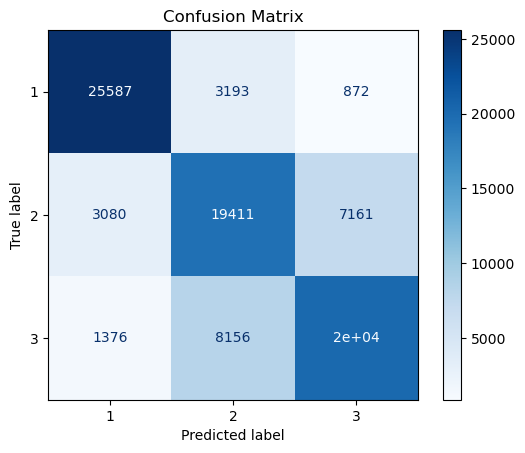

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation set
y_val_pred_probs = model.predict(X_val_scaled)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_val_adj, y_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
